<a href="https://colab.research.google.com/github/osmarbraz/exemplos_Llama2/blob/main/Exemplos_Chunk_Overlap_Langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exemplo de divisão e sobreposiçao de texto usando Langchain

Cria a divisão de um texto em pedaços(chunks) para submeter a um LLM. Realiza a sobreposição(overlap) de parte do texto para manter a semântica entre os chunks.

Tipos de divisão:
- Token (palavras)
- Recursiva de Caracter
- Token (Tokenizador BERT)

Semelhante a uma janela deslizante.

Teste online da chunk(divisão) e overlap(overlap) usando um arquivo texto: https://chunkerizer.streamlit.app/

Entendendo o chunk e overlap
https://gustavo-espindola.medium.com/chunk-division-and-overlap-understanding-the-process-ade7eae1b2bd

LangChain: como dividir corretamente seus chunks(pedaços):
https://www.youtube.com/watch?v=n0uPzvGTFI0

Estratégias de chucking: https://www.pinecone.io/learn/chunking-strategies/

Como agrupar dados de texto - uma análise comparativa: https://towardsdatascience.com/how-to-chunk-text-data-a-comparative-analysis-3858c4a0997a

# 0 - Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## Data e hora de execução

In [ ]:
# Biblioteca de date
from datetime import datetime

data_e_hora_atuais = datetime.now()
data_e_hora_em_texto = data_e_hora_atuais.strftime('%d/%m/%Y %H:%M:%S')

print(data_e_hora_em_texto)

06/11/2023 13:30:01


## Tratamento de logs

Método para tratamento dos logs.

In [ ]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

## Identificando o ambiente Colab

Cria uma variável para identificar que o notebook está sendo executado no Google Colaboratory.

In [ ]:
# Biblioteca do sistema
import sys

# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## Versão Python

In [ ]:
# Biblioteca do sistema
import sys

print("Versão Python:", sys.version)

Versão Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


## Funções auxiliares

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))

    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))

# 1 - Instalação das bibliotecas

Biblioteca para manipular pdf

https://pypi.org/project/pypdf/

In [ ]:
!pip install pypdf==3.16.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 6.1 MB/s eta 0:00:00


Biblioteca que persiste os embeddings e realiza busca semântica.

https://pypi.org/project/chromadb/

Dependência do WebBaseLoader.

In [ ]:
!pip install chromadb==0.4.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 46

Biblioteca para realizar a divisão por token.

In [ ]:
!pip install tiktoken==0.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


Bibioteca LangChain é um framework de código aberto para o desenvolvimento de aplicações usando modelos de linguagem grandes.

https://pypi.org/project/langchain/

In [ ]:
!pip install langchain==0.0.323

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.0 MB/s eta 0:00:00


A Biblioteca A Biblioteca Transformers fornece APIs e ferramentas para baixar e treinar facilmente modelos pré-treinados de última geração para Processamento de linguagem natural, Visão computacional, Áudio, etc.

Fornece uma maneira direta de usar modelos pré-treinados.

In [ ]:
# Instala a última versão da biblioteca
# !pip install transformers

# A última versão do huggingface apresenta um problema:
# UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1`
# https://discuss.huggingface.co/t/help-with-llama-2-finetuning-setup/50035
# Usar a versão 4.31.0

# Instala uma versão específica da biblioteca
!pip install -U transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1


## Versão bibliotecas instaladas

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
backoff==2.2.1
bcrypt==4.0.1
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.10.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.2.2
bqplot==0.12.42
branca==0.6.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.1
chex==0.1.7
chroma-hnswlib==0.7.3
chromadb==0.4.15
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
coloredlogs==15.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.1
cryptography==41

# 2 - Tipos de divisão

https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed

## Divisor recursivo de caracteres

In [ ]:
#Import de bibliotecas
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_tamanho =26
chunk_sobreposicao = 4

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_tamanho,
    chunk_overlap=chunk_sobreposicao,
    length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
)

In [ ]:
# Divisor recursivo do texto
text1 = 'abcdefghijklmnopqrstuvwxyz'
r_splitter.split_text(text1)
# Saída - ['abcdefghijklmnopqrstuvwxyz']

['abcdefghijklmnopqrstuvwxyz']

In [ ]:
# Dividor de caracter do texto
text2 = 'abcdefghijklmnopqrstuvwxyzabcdefg'
r_splitter.split_text(text2)
# Saída - ['abcdefghijklmnopqrstuvwxyz', 'wxyzabcdefg']

['abcdefghijklmnopqrstuvwxyz', 'wxyzabcdefg']

In [ ]:
# Dividor recursivo de texto
text3 = "a b c d e f g h i j k l m n o p q r s t u v w x y z"
r_splitter.split_text(text3)
# Saída - ['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

## Divisor de caracter

In [ ]:
#Import de bibliotecas
from langchain.text_splitter import CharacterTextSplitter

chunk_tamanho =26
chunk_sobreposicao = 4

c_splitter = CharacterTextSplitter(
    chunk_size=chunk_tamanho,
    chunk_overlap=chunk_sobreposicao,
    length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
)

In [ ]:
# Dividor de caracter texto
c_splitter.split_text(text3)
# Saída - ['a b c d e f g h i j k l m n o p q r s t u v w x y z']

['a b c d e f g h i j k l m n o p q r s t u v w x y z']

In [ ]:
# Character Text Splitter with separator defined
# Divisor de caracter texto com separador definido
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_tamanho,
    chunk_overlap=chunk_sobreposicao,
    separator = ' '
)
c_splitter.split_text(text3)
# Saída - ['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

['a b c d e f g h i j k l m', 'l m n o p q r s t u v w x', 'w x y z']

## Divisor de token

In [ ]:
#Import de bibliotecas
from langchain.text_splitter import TokenTextSplitter

chunk_tamanho =26
chunk_sobreposicao = 4

t_splitter = TokenTextSplitter(
    chunk_size=chunk_tamanho,
    chunk_overlap=chunk_sobreposicao,
    length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
)

In [ ]:
# Dividor de token do texto
t_splitter.split_text(text1)
# Saída - ['abcdefghijklmnopqrstuvwxyz']

['abcdefghijklmnopqrstuvwxyz']

In [ ]:
# Dividor de token do texto
text4 = 'ab cd ef gh ij kl mn op qr st uv wx yz ab cd ef gh ij kl mn op qr st uv wx yz'
t_splitter.split_text(text4)
# Saída - ['ab cd ef gh ij kl mn op qr st uv wx yz ab cd ef gh',' cd ef gh ij kl mn op qr st uv wx yz']

['ab cd ef gh ij kl mn op qr st uv wx yz ab cd ef gh',
 ' cd ef gh ij kl mn op qr st uv wx yz']

# 3 - Divisão por Token

Quebra palavras ao meio.

## 3.1 - Manipulando documentos Texto

### Cria o texto

In [ ]:
# trecho de https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979', #As Vítimas algozes

texto = """
No interior e principalmente longe da vila, ou da freguesia e dos povoados há quase
sempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,
é a inimiga hipócrita que rende vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que não poderia existir, manter-se, medrar em outras condições locais, e em
outras condições do trabalho rural, e nem se confunde com a taberna regular que
em toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,
onde os lavradores ricos e pobres se provêem do que precisa a casa, quando não
lhes é possível esperar pelas remessas dos seus consigna­tários ou fregueses.
Essa parasita das fazendas e estabelecimentos agrícolas
das vizinhanças facilmente se pode conhecer por suas feições e modos
característicos, se nos é lícito dizer assim: uma se parece com todas e não há
hipótese em que alguma delas, por mais dissimulada que seja, chegue a perder o
cará­ter da família.
É uma pequena casa de taipa e coberta de telha, tendo às
vezes na frente varanda aberta pelos três lados, também coberta de telha e com
o teto sustido por esteios fortes, mas rudes e ainda mesmo tortos; as paredes
nem sempre são caiadas, o chão não tem assoalho nem ladrilho; quando há
varanda, abrem-se para ela uma porta e uma janela; dentro está a ven­da: entre
a porta e a janela encostado à parede um banco de pau, defronte um balcão tosco
e no bojo ou no espaço que se vê além, grotesca armação de tábuas contendo
garrafas, botijas, latas de tabaco em pó, a um canto algumas voltas de fumo em
rolo e uma ruim manta de carne-seca. Eis a venda.
Há muitas que nem chegam à opulência da que aí fica
descrita; em todas porém aparece humilde no fundo do quase vazio bojo a porta
baixa que comunica pelo corredor imundo com dois ou mais quartos escuros, onde
se recolhem as pingues colheitas agrícolas do vendelhão que aliás não tem
lavoura.
"""

### Divide e sobrepõe o texto

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import TokenTextSplitter

# Parâmetros
chunk_tamanho = 250
chunk_sobreposicao = 50

# Configura o divisor
text_splitter = TokenTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.create_documents([texto])

tempo_final = time.time()

print(f"Carregando e dividindo {len([texto])} documentos texto em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 1 documentos texto em 0.005661487579345703 segundos!


In [ ]:
print(len(chunks))

4


In [ ]:
print(chunks)

[Document(page_content='\nNo interior e principalmente longe da vila, ou da freguesia e dos povoados há quase\nsempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,\né a inimiga hipócrita que rende vassalagem à sua vítima.\nA venda de que falo é uma taberna especialíssima\nque não poderia existir, manter-se, medrar em outras condições locais, e em\noutras condições do trabalho rural, e nem se confunde com a taberna regular que\nem toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,\nonde os lavradores ricos e pobres se provêem do que precisa a casa, quando não\nlhes é possível esperar pelas remessas dos seus consign', metadata={'start_index': 0}), Document(page_content='io,\nonde os lavradores ricos e pobres se provêem do que precisa a casa, quando não\nlhes é possível esperar pelas remessas dos seus consigna\xadtários ou fregueses.\nEssa parasita das fazendas e estabelecimentos agrícolas\ndas vizinhanças facilmente se pode co

### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  qtde char : 650  qtde token : 108  start_index: 0


No interior e principalmente longe da vila, ou da freguesia e dos povoados há quase
sempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,
é a inimiga hipócrita que rende vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que não poderia existir, manter-se, medrar em outras condições locais, e em
outras condições do trabalho rural, e nem se confunde com a taberna regular que
em toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,
onde os lavradores ricos e pobres se provêem do que precisa a casa, quando não
lhes é possível esperar pelas remessas dos seus consign
-----------------------------------------------------------------------
chunk # 1  qtde char : 612  qtde token : 96  start_index: 512

io,
onde os lavradores ricos e pobres se provêem do que precisa a casa, quando não
lhes é possível esperar pelas remessas dos seus consigna­tários ou fr

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  qtde char : 650  qtde token : 108
chunk # 1  qtde char : 612  qtde token : 96
chunk # 2  qtde char : 609  qtde token : 107
chunk # 3  qtde char : 423  qtde token : 70
Maior chunk token: 108
Maior chunk character: 650


### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

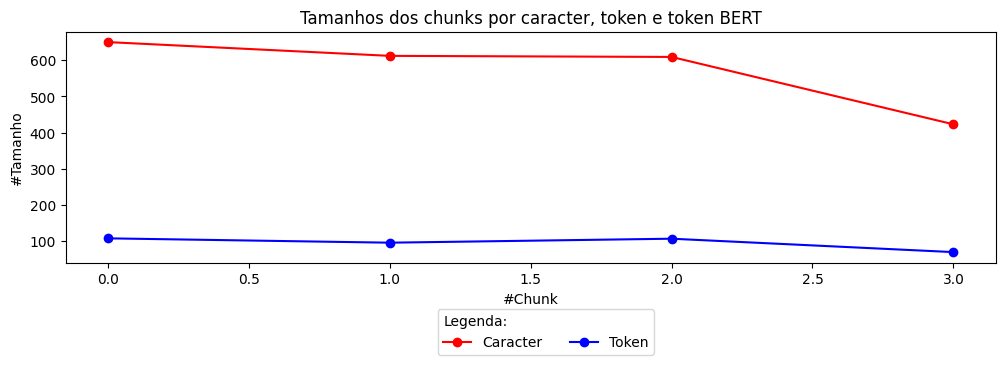

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

## 3.2 - Manipulando Documentos PDF

Gera um documento para cada a página do PDF.

https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf

### - Link dos PDFs

In [ ]:
# As Vítimas Algozes
url1 = 'https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116977'

# A Escrava Isaura
url2 = 'https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92390'

### Download dos pdfs

In [ ]:
# Import das bibliotecas
import subprocess

# As Vítimas Algozes

# Arquivo de destino1
destino1 = 'arquivo1.pdf'

# Executa o comando wget no prompt
subprocess.call(["wget", url1, "-O", destino1])

# Arquivo de destino1
destino2 = 'arquivo2.pdf'

# Executa o comando wget no prompt
subprocess.call(["wget", url2, "-O", destino2])

0

### Carrega os pdfs

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

# Define o diretório
diretorio = '/content'

 # Cria o carregador do PDF
carregador = PyPDFDirectoryLoader(diretorio)

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os pdfs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import TokenTextSplitter

# Parâmetros
chunk_tamanho = 250
chunk_sobreposicao = 50

# Configura o divisor
text_splitter = TokenTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos pdfs em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 649 documentos pdfs em 0.18903779983520508 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i,' Doc:',chunk.metadata['source'],' Pág:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: /content/arquivo1.pdf  Pág: 0  qtde char : 376  qtde token : 47  start_index: 0

J MAS-ALGOZE 
ROMAM 
~% 
LIVRARIA DE B. L. GARNIER 
«9, rua do Ouvidor, CO 
Grandesortimento del.ivros clássicos, Medicina, 
Sciencias e Arlís, Junsprudcncia, Littsratura, 
Novellas, lllustrações, Educação, Devoção, Atlas, 
Happas geographicos, etc, etc. 
Livros francezes, portuguezes, inqlezes, italianos, ele-, 
Encarrega-se áe qualquer conmissio de Liuros-
BIO DE JIMIIIO 
-----------------------------------------------------------------------
chunk # 1  Doc: /content/arquivo1.pdf  Pág: 1  qtde char : 79  qtde token : 14  start_index: 0

Ie ne fay rien 
sans 
Gayeté 
(Montaigne, Des livres) 
Ex Libris 
José Mindlin 
-----------------------------------------------------------------------
chunk # 2  Doc: /content/arquivo1.pdf  Pág: 2  qtde char : 20  qtde token : 3  start_index: 0

AS VICTIMAS-ALGOZES 
-----------------------------------------------------------------------
chunk # 3  Doc: /c

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' Doc:',chunk.metadata['source'],' Pág:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: /content/arquivo1.pdf  Pág: 0  qtde char : 376  qtde token : 47
chunk # 1  Doc: /content/arquivo1.pdf  Pág: 1  qtde char : 79  qtde token : 14
chunk # 2  Doc: /content/arquivo1.pdf  Pág: 2  qtde char : 20  qtde token : 3
chunk # 3  Doc: /content/arquivo1.pdf  Pág: 4  qtde char : 155  qtde token : 26
chunk # 4  Doc: /content/arquivo1.pdf  Pág: 6  qtde char : 583  qtde token : 93
chunk # 5  Doc: /content/arquivo1.pdf  Pág: 6  qtde char : 119  qtde token : 20
chunk # 6  Doc: /content/arquivo1.pdf  Pág: 7  qtde char : 601  qtde token : 100
chunk # 7  Doc: /content/arquivo1.pdf  Pág: 7  qtde char : 396  qtde token : 61
chunk # 8  Doc: /content/arquivo1.pdf  Pág: 8  qtde char : 625  qtde token : 97
chunk # 9  Doc: /content/arquivo1.pdf  Pág: 8  qtde char : 543  qtde token : 85
chunk # 10  Doc: /content/arquivo1.pdf  Pág: 8  qtde char : 65  qtde token : 9
chunk # 11  Doc: /content/arquivo1.pdf  Pág: 9  qtde char : 619  qtde token : 99
chunk # 12  Doc: /content/arquivo1.pdf  Pá

### Estatisticas dos Chunks

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

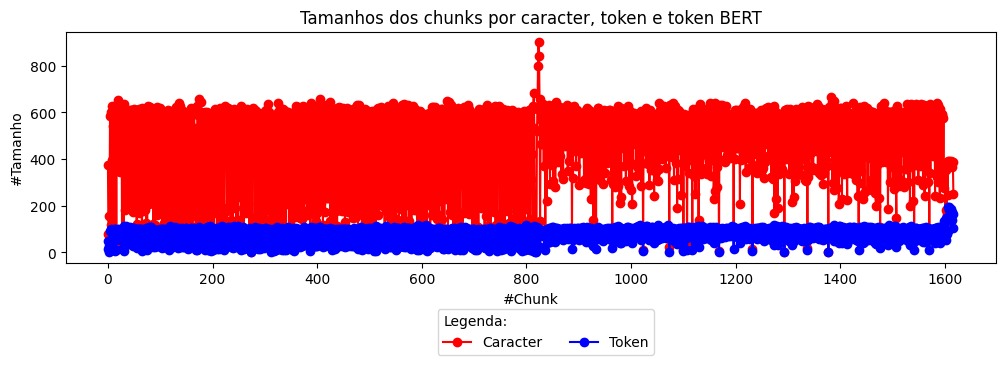

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

## 3.3 - Manipulando Documentos HTML

Gera um único documento para a página HTML.

https://python.langchain.com/docs/integrations/document_loaders/web_base

### Links dos HTML

In [ ]:
# As Vítimas Algozes
url1 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979"

# A Escrava Isaura
url2 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92389"

### Carrega os HTMLs

Se ocorrer o **erro** abaixo, instale o Chromedb. Alguma dependência do pacote resolve o problema.

---------------------------------------------------------------------------
IncompleteRead                            Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/urllib3/response.py in _error_catcher(self)
    709             try:
--> 710                 yield
    711

15 frames
IncompleteRead: IncompleteRead(821958 bytes read, 2240625 more expected)

The above exception was the direct cause of the following exception:

ProtocolError                             Traceback (most recent call last)
ProtocolError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

During handling of the above exception, another exception occurred:

ChunkedEncodingError                      Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/requests/models.py in generate()
    816                     yield from self.raw.stream(chunk_size, decode_content=True)
    817                 except ProtocolError as e:
--> 818                     raise ChunkedEncodingError(e)
    819                 except DecodeError as e:
    820                     raise ContentDecodingError(e)

ChunkedEncodingError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import WebBaseLoader

# Cria o carregador da página
carregador = WebBaseLoader([url1, url2])
# carregador.requests_kwargs = {'verify':False}

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os HTMLs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import TokenTextSplitter

# Parâmetros
chunk_tamanho = 500
chunk_sobreposicao = 100

# Configura o divisor
text_splitter = TokenTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos htmls em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 2 documentos htmls em 0.38165926933288574 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1199  qtde token : 165

















As vítimas algozes - Joaquim Manuel de Macedo



Fonte: Biblioteca Digital de Literatura de Países Lusófonos

LITERATURA BRASILEIRA 
Textos literários em
meio eletrônico
As
Vítimas-Algozes, de Joaquim Manuel de Macedo

Edição de base:
Biblioteca Nacional – setor de obras digitalizadas
ÍNDICE
SIMEÃO, O CRIOULO
PAI- RAIOL, O FEITICEIRO
LUCINDA, A
MUCAMA
CONCLUSÃO
I
SIMEÃO, O CRIOULO
I
No interior e principalmente longe da vila, ou da
freguesia e dos povoados há quase sempre uma venda perto da fazenda: é a
parasita que se apega à árvore; pior que isso, é a inimiga hipócrita que rende
vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que não poderia existir, manter-se, medrar em outras condições locais, e em
outras condições do trabalho rural, e nem se confunde com a taberna regular que
em toda parte se encontra, quanto 

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1199  qtde token : 165
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1214  qtde token : 203
chunk # 2  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1227  qtde token : 201
chunk # 3  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1250  qtde token : 196
chunk # 4  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1246  qtde token : 186
chunk # 5  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1251  qtde token : 198
chunk # 6  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1187  qtde token : 187
chunk # 7  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=downloa

### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

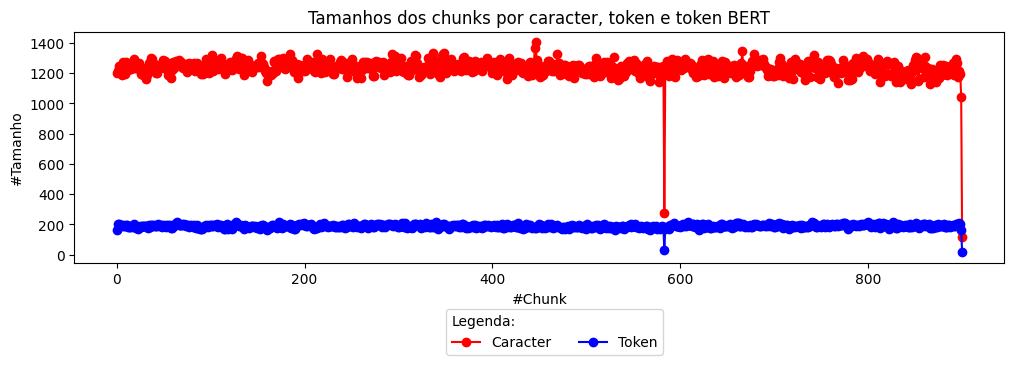

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

# 4 - Divisão Recursiva de Caracter

## 4.1 - Manipulando documentos Texto

### Cria o texto

In [ ]:
# trecho de https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979', #As Vítimas algozes


texto = """
No interior e principalmente longe da vila, ou da freguesia e dos povoados há quase
sempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,
é a inimiga hipócrita que rende vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que não poderia existir, manter-se, medrar em outras condições locais, e em
outras condições do trabalho rural, e nem se confunde com a taberna regular que
em toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,
onde os lavradores ricos e pobres se provêem do que precisa a casa, quando não
lhes é possível esperar pelas remessas dos seus consigna­tários ou fregueses.
Essa parasita das fazendas e estabelecimentos agrícolas
das vizinhanças facilmente se pode conhecer por suas feições e modos
característicos, se nos é lícito dizer assim: uma se parece com todas e não há
hipótese em que alguma delas, por mais dissimulada que seja, chegue a perder o
cará­ter da família.
É uma pequena casa de taipa e coberta de telha, tendo às
vezes na frente varanda aberta pelos três lados, também coberta de telha e com
o teto sustido por esteios fortes, mas rudes e ainda mesmo tortos; as paredes
nem sempre são caiadas, o chão não tem assoalho nem ladrilho; quando há
varanda, abrem-se para ela uma porta e uma janela; dentro está a ven­da: entre
a porta e a janela encostado à parede um banco de pau, defronte um balcão tosco
e no bojo ou no espaço que se vê além, grotesca armação de tábuas contendo
garrafas, botijas, latas de tabaco em pó, a um canto algumas voltas de fumo em
rolo e uma ruim manta de carne-seca. Eis a venda.
Há muitas que nem chegam à opulência da que aí fica
descrita; em todas porém aparece humilde no fundo do quase vazio bojo a porta
baixa que comunica pelo corredor imundo com dois ou mais quartos escuros, onde
se recolhem as pingues colheitas agrícolas do vendelhão que aliás não tem
lavoura.
"""

### Divide e sobrepõe o texto

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Parâmetros
chunk_tamanho = 250
chunk_sobreposicao = 50

# Configura o divisor
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.create_documents([texto])

tempo_final = time.time()

print(f"Carregando e dividindo {len([texto])} documentos texto em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 1 documentos texto em 0.0008082389831542969 segundos!


In [ ]:
print(len(chunks))

2


In [ ]:
print(chunks)

[Document(page_content='No interior e principalmente longe da vila, ou da freguesia e dos povoados há quase\nsempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,\né a inimiga hipócrita que rende vassalagem à sua vítima.\nA venda de que falo é uma taberna especialíssima\nque não poderia existir, manter-se, medrar em outras condições locais, e em\noutras condições do trabalho rural, e nem se confunde com a taberna regular que\nem toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,\nonde os lavradores ricos e pobres se provêem do que precisa a casa, quando não\nlhes é possível esperar pelas remessas dos seus consigna\xadtários ou fregueses.\nEssa parasita das fazendas e estabelecimentos agrícolas\ndas vizinhanças facilmente se pode conhecer por suas feições e modos\ncaracterísticos, se nos é lícito dizer assim: uma se parece com todas e não há\nhipótese em que alguma delas, por mais dissimulada que seja, chegue a perder o\ncará\

### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  qtde char : 1261  qtde token : 204  start_index: 1

No interior e principalmente longe da vila, ou da freguesia e dos povoados há quase
sempre uma venda perto da fazenda: é a parasita que se apega à árvore; pior que isso,
é a inimiga hipócrita que rende vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que não poderia existir, manter-se, medrar em outras condições locais, e em
outras condições do trabalho rural, e nem se confunde com a taberna regular que
em toda parte se encontra, quanto mais com as casas de grande ou pequeno comércio,
onde os lavradores ricos e pobres se provêem do que precisa a casa, quando não
lhes é possível esperar pelas remessas dos seus consigna­tários ou fregueses.
Essa parasita das fazendas e estabelecimentos agrícolas
das vizinhanças facilmente se pode conhecer por suas feições e modos
característicos, se nos é lícito dizer assim: uma se parece com todas e não há
hipótese em que alguma delas, por mais dissimulada que seja, 

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  qtde char : 1261  qtde token : 204
chunk # 1  qtde char : 883  qtde token : 150
Maior chunk token: 204
Maior chunk character: 1261


### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

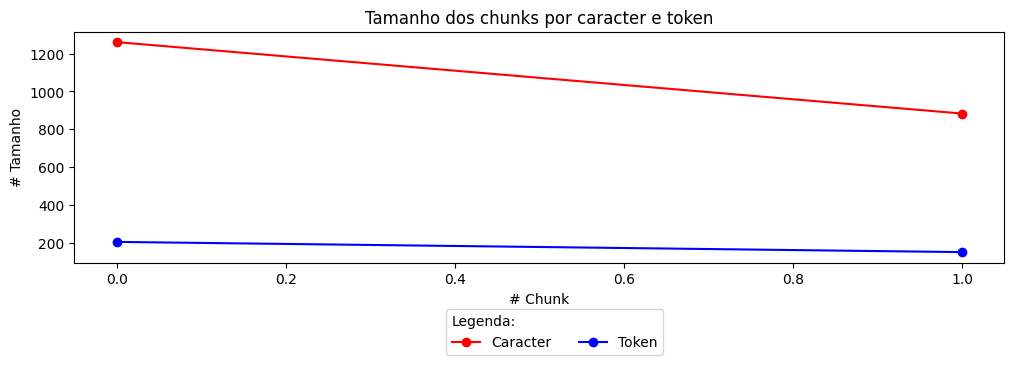

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))

plt.title("Tamanho dos chunks por caracter e token")
plt.ylabel("# Tamanho")
plt.xlabel('# Chunk')

plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
# plt.legend(title = 'Legenda:')._legend_box.align='bottom'

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(title = "Legenda:")._legend_box.align='left'

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='left'

plt.show()

## 4.2 - Manipulando Documentos PDF

Gera um documento para cada a página do PDF.

https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf

### - Link dos PDFs

In [ ]:
# As Vítimas Algozes
url1 = 'https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116977'

# A Escrava Isaura
url2 = 'https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92390'

### Download dos pdfs

Usando wget

In [ ]:
# Import das bibliotecas
import subprocess

# Arquivo de destino1
destino1 = 'arquivo1.pdf'

# Executa o comando wget no prompt
subprocess.call(["wget", url1, "-O", destino1])

# Arquivo de destino1
destino2 = 'arquivo2.pdf'

# Executa o comando wget no prompt
subprocess.call(["wget", url1, "-O", destino2])

0

Ou com usando o curl

In [ ]:
# #Import das bibliotecas
# import subprocess

# # Arquivo de destino1
# destino1 = 'arquivo1.pdf'

# # Executa o comando wget no prompt
# subprocess.call(["wget", url1, "-O", destino1])

# # Arquivo de destino1
# destino2 = 'arquivo2.pdf'

# # Executa o comando curl no prompt
# subprocess.call(["curl", "-o", destino, arquivo])

### Carrega os pdfs

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

# Define o diretório
diretorio = '/content'

 # Cria o carregador do PDF
carregador = PyPDFDirectoryLoader(diretorio)

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os pdfs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Parâmetros
chunk_tamanho = 250
chunk_sobreposicao = 100

# Configura o divisor
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos pdfs em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 706 documentos pdfs em 0.040148019790649414 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i,' Doc:',chunk.metadata['source'],' Pág:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: /content/arquivo1.pdf  Pág: 0  qtde char : 375  qtde token : 46  start_index: 0

J MAS-ALGOZE 
ROMAM 
~% 
LIVRARIA DE B. L. GARNIER 
«9, rua do Ouvidor, CO 
Grandesortimento del.ivros clássicos, Medicina, 
Sciencias e Arlís, Junsprudcncia, Littsratura, 
Novellas, lllustrações, Educação, Devoção, Atlas, 
Happas geographicos, etc, etc. 
Livros francezes, portuguezes, inqlezes, italianos, ele-, 
Encarrega-se áe qualquer conmissio de Liuros-
BIO DE JIMIIIO
-----------------------------------------------------------------------
chunk # 1  Doc: /content/arquivo1.pdf  Pág: 1  qtde char : 78  qtde token : 13  start_index: 0

Ie ne fay rien 
sans 
Gayeté 
(Montaigne, Des livres) 
Ex Libris 
José Mindlin
-----------------------------------------------------------------------
chunk # 2  Doc: /content/arquivo1.pdf  Pág: 2  qtde char : 19  qtde token : 2  start_index: 0

AS VICTIMAS-ALGOZES
-----------------------------------------------------------------------
chunk # 3  Doc: /cont

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    tokens = chunk.page_content.split(" ")
    print('chunk #',i,' Doc:',chunk.metadata['source'],' Pág:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' start_index:', chunk.metadata.get('start_index') )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: /content/arquivo1.pdf  Pág: 0  qtde char : 375  qtde token : 46  start_index: 0
chunk # 1  Doc: /content/arquivo1.pdf  Pág: 1  qtde char : 78  qtde token : 13  start_index: 0
chunk # 2  Doc: /content/arquivo1.pdf  Pág: 2  qtde char : 19  qtde token : 2  start_index: 0
chunk # 3  Doc: /content/arquivo1.pdf  Pág: 4  qtde char : 154  qtde token : 25  start_index: 0
chunk # 4  Doc: /content/arquivo1.pdf  Pág: 6  qtde char : 589  qtde token : 94  start_index: 0
chunk # 5  Doc: /content/arquivo1.pdf  Pág: 7  qtde char : 875  qtde token : 139  start_index: 0
chunk # 6  Doc: /content/arquivo1.pdf  Pág: 8  qtde char : 1047  qtde token : 163  start_index: 0
chunk # 7  Doc: /content/arquivo1.pdf  Pág: 9  qtde char : 1039  qtde token : 162  start_index: 0
chunk # 8  Doc: /content/arquivo1.pdf  Pág: 10  qtde char : 997  qtde token : 166  start_index: 0
chunk # 9  Doc: /content/arquivo1.pdf  Pág: 11  qtde char : 834  qtde token : 136  start_index: 0
chunk # 10  Doc: /content/arquivo1

### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

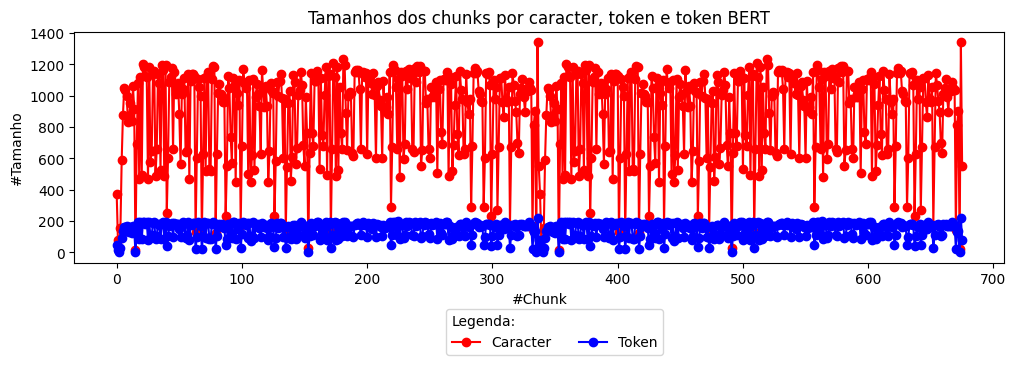

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

## 4.3 - Manipulando Documentos HTML

Gera um único documento para a página HTML.

https://python.langchain.com/docs/integrations/document_loaders/web_base

### Links dos HTML

In [ ]:
# As Vítimas Algozes
url1 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979"

# A Escrava Isaura
url2 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92389"

### Carrega os HTMLs

Se ocorrer o **erro** abaixo, instale o Chromedb. Alguma dependência do pacote resolve o problema.

---------------------------------------------------------------------------
IncompleteRead                            Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/urllib3/response.py in _error_catcher(self)
    709             try:
--> 710                 yield
    711

15 frames
IncompleteRead: IncompleteRead(821958 bytes read, 2240625 more expected)

The above exception was the direct cause of the following exception:

ProtocolError                             Traceback (most recent call last)
ProtocolError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

During handling of the above exception, another exception occurred:

ChunkedEncodingError                      Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/requests/models.py in generate()
    816                     yield from self.raw.stream(chunk_size, decode_content=True)
    817                 except ProtocolError as e:
--> 818                     raise ChunkedEncodingError(e)
    819                 except DecodeError as e:
    820                     raise ContentDecodingError(e)

ChunkedEncodingError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import WebBaseLoader

# Cria o carregador da página
carregador = WebBaseLoader([url1, url2])
# carregador.requests_kwargs = {'verify':False}

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os HTMLs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Parâmetros
chunk_tamanho = 500
chunk_sobreposicao = 100

# Configura o divisor
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    # length_function = len, # Usa o comprimento do texto em caracteres como medida de tamanho
    length_function = lambda x: len(x.split(" ")), # Usa a quantidade de tokens separados por espaço em branco como medida de tamanho
    add_start_index = True, #
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos htmls em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 2 documentos htmls em 0.10756635665893555 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 20:
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    print()
    print(chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25

As vítimas algozes - Joaquim Manuel de Macedo



Fonte: Biblioteca Digital de Literatura de Países Lusófonos

LITERATURA BRASILEIRA 
Textos literários em
meio eletrônico
As
Vítimas-Algozes, de Joaquim Manuel de Macedo
-----------------------------------------------------------------------
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2516  qtde token : 401

Edição de base:
Biblioteca Nacional – setor de obras digitalizadas
ÍNDICE
SIMEÃO, O CRIOULO
PAI- RAIOL, O FEITICEIRO
LUCINDA, A
MUCAMA
CONCLUSÃO
I
SIMEÃO, O CRIOULO
I
No interior e principalmente longe da vila, ou da
freguesia e dos povoados há quase sempre uma venda perto da fazenda: é a
parasita que se apega à árvore; pior que isso, é a inimiga hipócrita que rende
vassalagem à sua vítima.
A venda de que falo é uma taberna especialíssima
que n

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_character = 0
for i, chunk in enumerate(chunks):
    # Divide os tokens pelo espaço em branco
    tokens = chunk.page_content.split(" ")
    print('chunk #',i, ' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens) )
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2516  qtde token : 401
chunk # 2  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2739  qtde token : 419
chunk # 3  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2615  qtde token : 404
chunk # 4  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2626  qtde token : 406
chunk # 5  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2620  qtde token : 403
chunk # 6  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 2637  qtde token : 407
chunk # 7  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&

### Estatisticas dos Chunks

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")

  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))

Gera os dados para o gráfico

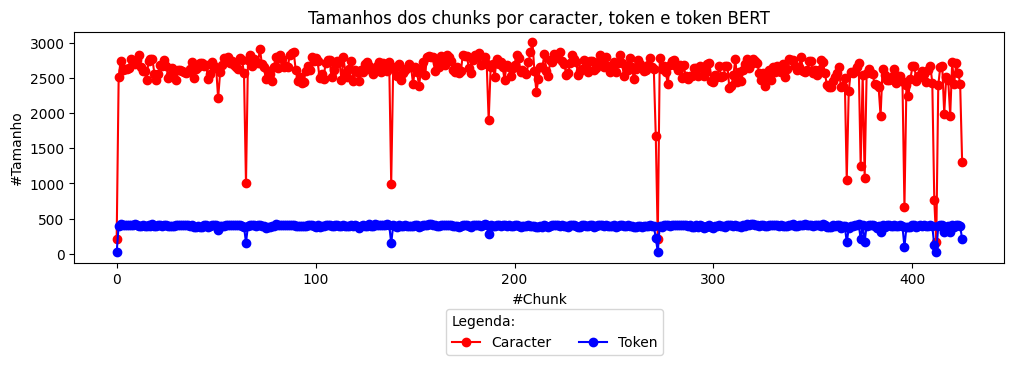

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.4, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

# 5 - Divisão Recursiva de Caracter e Tokenizador

## 5.1 - Carregando o LM



### Nome do LM BERT

In [ ]:
# Modelos em Inglês
#nome_modelo_bert = "bert-large-cased"
#nome_modelo_bert = "bert-base-cased"

# Modelos em Português
nome_modelo_bert = "neuralmind/bert-large-portuguese-cased"
#nome_modelo_bert = "neuralmind/bert-base-portuguese-cased"

### Carregando o LM BERT



Carrega o tokenizador do bert

In [ ]:
# Importando as bibliotecas do Tokenizador
from transformers import AutoTokenizer

# Carregando o Tokenizador da comunidade
print('Carregando o tokenizador ' + nome_modelo_bert + ' da comunidade...')

tokenizer_bert = AutoTokenizer.from_pretrained(nome_modelo_bert)

Carregando o tokenizador neuralmind/bert-large-portuguese-cased da comunidade...


Tamanho do vocabulário BERT

In [ ]:
print(len(tokenizer_bert))

29794


## 5.2 - Divisão com from_hugginface_tokenizer

Artigos que auxiliaram a criar o recuperador de texto de perguntas em texto longo.

https://heidloff.net/article/retrieval-augmented-generation-chroma-langchain/

https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed

### Links dos HTML

In [ ]:
# As Vítimas Algozes
url1 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979"

# A Escrava Isaura
url2 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92389"

### Carrega os HTMLs

Se ocorrer o **erro** abaixo, instale o Chromedb. Alguma dependência do pacote resolve o problema.

---------------------------------------------------------------------------
IncompleteRead                            Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/urllib3/response.py in _error_catcher(self)
    709             try:
--> 710                 yield
    711

15 frames
IncompleteRead: IncompleteRead(821958 bytes read, 2240625 more expected)

The above exception was the direct cause of the following exception:

ProtocolError                             Traceback (most recent call last)
ProtocolError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

During handling of the above exception, another exception occurred:

ChunkedEncodingError                      Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/requests/models.py in generate()
    816                     yield from self.raw.stream(chunk_size, decode_content=True)
    817                 except ProtocolError as e:
--> 818                     raise ChunkedEncodingError(e)
    819                 except DecodeError as e:
    820                     raise ContentDecodingError(e)

ChunkedEncodingError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import WebBaseLoader

# Cria o carregador da página
carregador = WebBaseLoader([url1, url2])
# carregador.requests_kwargs = {'verify':False}

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os HTMLs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Parâmetros
chunk_tamanho = 500
chunk_sobreposicao = 100

# Configura o divisor
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer_bert,
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    add_start_index = True, # Adiciona o índice de início do chunk no documento
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos htmls em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 2 documentos htmls em 3.174262285232544 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 10:
    # Divide o chunk pelo espaço em branco
    tokens = chunk.page_content.split(" ")

    # Divide o chunk pelo tokenizador do BERT
    tokens_bert = tokenizer_bert.tokenize(chunk.page_content)

    # Documento HTML
    print('chunk #',i,' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    print('    Tokens bert:', len(tokens_bert), ' Tokens:' , tokens_bert)
    # Documento PDF
    # print('chunk #',i,' Doc:',chunk.metadata['source'],' Página:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print('       ', chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25  qtde token bert: 50  start_index: 16
    Tokens bert: 50  Tokens: ['As', 'vítimas', 'algo', '##zes', '-', 'Joaquim', 'Manuel', 'de', 'Macedo', 'Fonte', ':', 'Biblioteca', 'Digital', 'de', 'Literatura', 'de', 'Países', 'Lus', '##ófon', '##os', 'L', '##IT', '##ER', '##AT', '##UR', '##A', 'BR', '##AS', '##IL', '##EI', '##RA', 'Tex', '##tos', 'literários', 'em', 'meio', 'eletrônico', 'As', 'Ví', '##timas', '-', 'Al', '##go', '##zes', ',', 'de', 'Joaquim', 'Manuel', 'de', 'Macedo']

        As vítimas algozes - Joaquim Manuel de Macedo



Fonte: Biblioteca Digital de Literatura de Países Lusófonos

LITERATURA BRASILEIRA 
Textos literários em
meio eletrônico
As
Vítimas-Algozes, de Joaquim Manuel de Macedo
-----------------------------------------------------------------------
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=1

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_token_bert = 0
maior_chunk_character = 0

for i, chunk in enumerate(chunks):
    # Divide o chunk pelo espaço em branco
    tokens = chunk.page_content.split(" ")

    # Divide o chunk pelo tokenizador do BERT
    tokens_bert = tokenizer_bert.tokenize(chunk.page_content)

    # Documento HTML
    print('chunk #',i,' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    # Documento PDF
    #print('chunk #',i,' Doc:',chunk.metadata['source'],' Página:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert),' start_index:', chunk.metadata.get('start_index') )

    # Procura os maiores valores
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(tokens_bert) > maior_chunk_token_bert:
      maior_chunk_token_bert = len(tokens_bert)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk token bert:", maior_chunk_token_bert)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25  qtde token bert: 50  start_index: 16
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1429  qtde token : 220  qtde token bert: 361  start_index: 235
chunk # 2  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1530  qtde token : 253  qtde token bert: 394  start_index: 1357
chunk # 3  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1602  qtde token : 250  qtde token bert: 403  start_index: 2605
chunk # 4  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1623  qtde token : 244  qtde token bert: 406  start_index: 3902
chunk # 5  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1552  qtde token : 237  qtde token ber

### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
chunks_tamanhos_token_bert = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")
  # Divide o chunk pelo tokenizador do BERT
  tokens_bert = tokenizer_bert.tokenize(chunk.page_content)
  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))
  chunks_tamanhos_token_bert.append(len(tokens_bert))

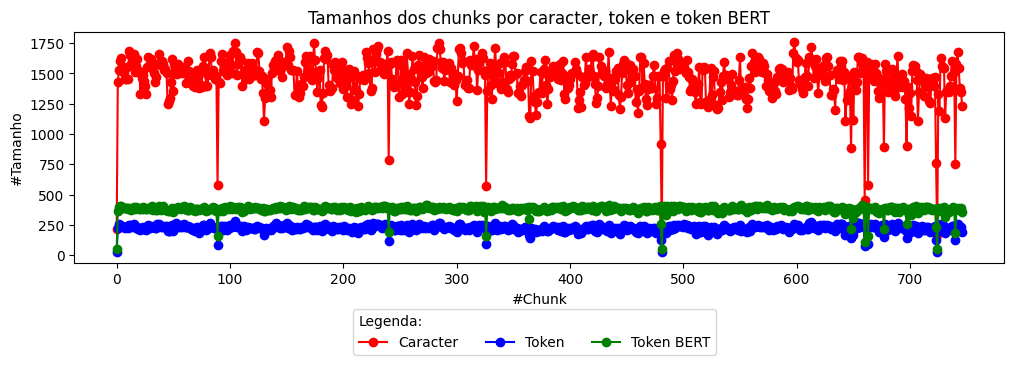

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")
plt.plot(chunks_tamanhos_token_bert,'g-',marker='o', label = "Token BERT")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.3, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()

## 5.3 - Divisão com len(tokenizer)

Artigos que auxiliaram a criar o recuperador de texto de perguntas em texto longo.

https://heidloff.net/article/retrieval-augmented-generation-chroma-langchain/

https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed

### Links dos HTML

In [ ]:
# As Vítimas Algozes
url1 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979"

# A Escrava Isaura
url2 = "https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=92389"

### Carrega os HTMLs

Se ocorrer o **erro** abaixo, instale o Chromedb. Alguma dependência do pacote resolve o problema.

---------------------------------------------------------------------------
IncompleteRead                            Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/urllib3/response.py in _error_catcher(self)
    709             try:
--> 710                 yield
    711

15 frames
IncompleteRead: IncompleteRead(821958 bytes read, 2240625 more expected)

The above exception was the direct cause of the following exception:

ProtocolError                             Traceback (most recent call last)
ProtocolError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

During handling of the above exception, another exception occurred:

ChunkedEncodingError                      Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/requests/models.py in generate()
    816                     yield from self.raw.stream(chunk_size, decode_content=True)
    817                 except ProtocolError as e:
--> 818                     raise ChunkedEncodingError(e)
    819                 except DecodeError as e:
    820                     raise ContentDecodingError(e)

ChunkedEncodingError: ('Connection broken: IncompleteRead(821958 bytes read, 2240625 more expected)', IncompleteRead(821958 bytes read, 2240625 more expected))

In [ ]:
# Import das bibliotecas
from langchain.document_loaders import WebBaseLoader

# Cria o carregador da página
carregador = WebBaseLoader([url1, url2])
# carregador.requests_kwargs = {'verify':False}

# Carrega os documentos
documentos = carregador.load()

### Divide e sobrepõe os HTMLs

In [ ]:
# Import das bibliotecas
import os
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Parâmetros
chunk_tamanho = 500
chunk_sobreposicao = 100

# Configura o divisor
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_tamanho, # Tamanho do pedaço (chunk) de texto a ser gerado
    chunk_overlap  = chunk_sobreposicao, # Número de tokens sobrepostos entre chunks(pedaços)
    length_function = lambda x: len(tokenizer_bert.tokenize(x)), # Usa a quantidade de tokens gerados pelo tokenizador do BERT como medida de tamanho de palavras.
    add_start_index = True, # Adiciona o índice de início do chunk no documento
)

# Guarda o tempo de início
tempo_inicio = time.time()

# Calcula os chunks dos textos
chunks = text_splitter.split_documents(documentos)

tempo_final = time.time()

print(f"Carregando e dividindo {len(documentos)} documentos htmls em {tempo_final - tempo_inicio} segundos!")

Carregando e dividindo 2 documentos htmls em 3.2766451835632324 segundos!


### Mostra os chunks

A sobreposição se encontra ao final e início de cada pedaço(chunk). A variável 'start_index' define onde começa o texto sem a sobreposição.

In [ ]:
for i, chunk in enumerate(chunks):
  if i < 10:
    # Divide o chunk pelo espaço em branco
    tokens = chunk.page_content.split(" ")

    # Divide o chunk pelo tokenizador do BERT
    tokens_bert = tokenizer_bert.tokenize(chunk.page_content)

    # Documento HTML
    print('chunk #',i,' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    print('    Tokens bert:', len(tokens_bert), ' Tokens:' , tokens_bert)
    # Documento PDF
    # print('chunk #',i,' Doc:',chunk.metadata['source'],' Página:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    print()
    print('       ', chunk.page_content)
    print('-----------------------------------------------------------------------')

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25  qtde token bert: 50  start_index: 16
    Tokens bert: 50  Tokens: ['As', 'vítimas', 'algo', '##zes', '-', 'Joaquim', 'Manuel', 'de', 'Macedo', 'Fonte', ':', 'Biblioteca', 'Digital', 'de', 'Literatura', 'de', 'Países', 'Lus', '##ófon', '##os', 'L', '##IT', '##ER', '##AT', '##UR', '##A', 'BR', '##AS', '##IL', '##EI', '##RA', 'Tex', '##tos', 'literários', 'em', 'meio', 'eletrônico', 'As', 'Ví', '##timas', '-', 'Al', '##go', '##zes', ',', 'de', 'Joaquim', 'Manuel', 'de', 'Macedo']

        As vítimas algozes - Joaquim Manuel de Macedo



Fonte: Biblioteca Digital de Literatura de Países Lusófonos

LITERATURA BRASILEIRA 
Textos literários em
meio eletrônico
As
Vítimas-Algozes, de Joaquim Manuel de Macedo
-----------------------------------------------------------------------
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=1

Estatísticas dos chunks

In [ ]:
maior_chunk_token = 0
maior_chunk_token_bert = 0
maior_chunk_character = 0

for i, chunk in enumerate(chunks):
    # Divide o chunk pelo espaço em branco
    tokens = chunk.page_content.split(" ")

    # Divide o chunk pelo tokenizador do BERT
    tokens_bert = tokenizer_bert.tokenize(chunk.page_content)

    # Documento HTML
    print('chunk #',i,' Doc:',chunk.metadata['source'],' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert), ' start_index:', chunk.metadata.get('start_index') )
    # Documento PDF
    #print('chunk #',i,' Doc:',chunk.metadata['source'],' Página:', chunk.metadata['page'], ' qtde char :', len(chunk.page_content),' qtde token :', len(tokens), ' qtde token bert:', len(tokens_bert),' start_index:', chunk.metadata.get('start_index') )

    # Procura os maiores valores
    if len(tokens) > maior_chunk_token:
      maior_chunk_token = len(tokens)
    if len(tokens_bert) > maior_chunk_token_bert:
      maior_chunk_token_bert = len(tokens_bert)
    if len(chunk.page_content) > maior_chunk_character:
      maior_chunk_character = len(chunk.page_content)

print("Maior chunk token:", maior_chunk_token)
print("Maior chunk token bert:", maior_chunk_token_bert)
print("Maior chunk character:", maior_chunk_character)

chunk # 0  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 217  qtde token : 25  qtde token bert: 50  start_index: 16
chunk # 1  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1922  qtde token : 308  qtde token bert: 497  start_index: 235
chunk # 2  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1956  qtde token : 316  qtde token bert: 494  start_index: 1824
chunk # 3  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1972  qtde token : 301  qtde token bert: 495  start_index: 3412
chunk # 4  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1907  qtde token : 299  qtde token bert: 483  start_index: 5000
chunk # 5  Doc: https://www.literaturabrasileira.ufsc.br/documentos/?action=download&id=116979  qtde char : 1907  qtde token : 297  qtde token ber

### Estatisticas dos Chunks

Gera os dados para o gráfico

In [ ]:
chunks_tamanhos_char = []
chunks_tamanhos_token = []
chunks_tamanhos_token_bert = []
for i, chunk in enumerate(chunks):
  # Divide os tokens pelo espaço em branco
  tokens = chunk.page_content.split(" ")
  # Divide o chunk pelo tokenizador do BERT
  tokens_bert = tokenizer_bert.tokenize(chunk.page_content)
  chunks_tamanhos_char.append(len(chunk.page_content))
  chunks_tamanhos_token.append(len(tokens))
  chunks_tamanhos_token_bert.append(len(tokens_bert))

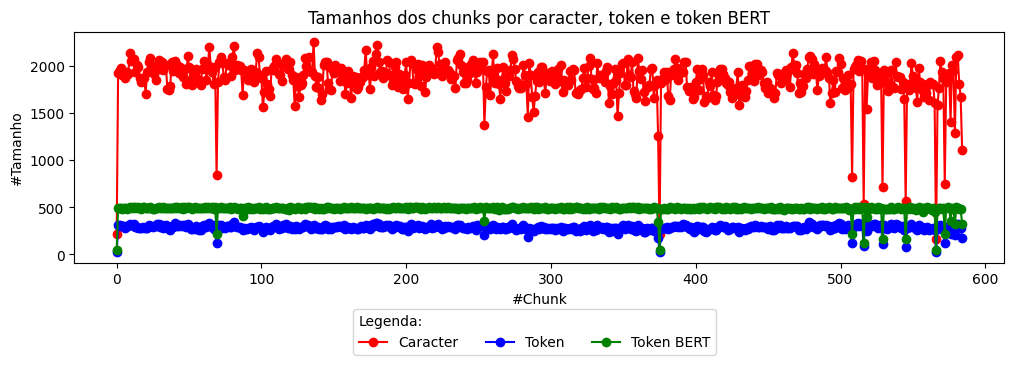

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt

# Tamanho da figura
plt.figure(figsize=(12, 3))

# Dados do gráfico
plt.title("Tamanhos dos chunks por caracter, token e token BERT")
plt.ylabel("#Tamanho")
plt.xlabel('#Chunk')

# Plota os dados
plt.plot(chunks_tamanhos_char,'r-',marker='o', label = "Caracter")
plt.plot(chunks_tamanhos_token,'b-',marker='o', label = "Token")
plt.plot(chunks_tamanhos_token_bert,'g-',marker='o', label = "Token BERT")

# Insere e o título da legenda e por padrão usa o label de cada gráfico.
plt.legend(loc=(0.3, -0.4), ncol=3, title = "Legenda:")._legend_box.align='bottom'

plt.show()